In [1]:
import pickle
import torch.utils.data
import torch
from seagul.rl.run_utils import load_model, load_workspace
import numpy as np
from numpy import pi
import matplotlib.pyplot as plt
from pprint import pprint
import pandas as pd
from seagul.rl.models import PpoModel, switchedPpoModel
from seagul.nn import MLP
import gym
torch.set_default_dtype(torch.double)

#load_path = './data/mj_baseline7/acrobot73380899'
#load_path = './data/inv_pend/acrobot_116_3'

Text(0.5, 1.0, 'Reward curve vanilla PPO with action hold')

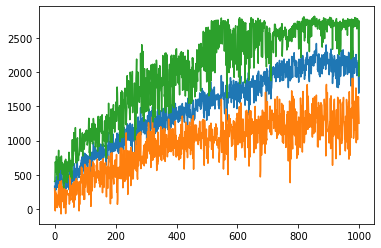

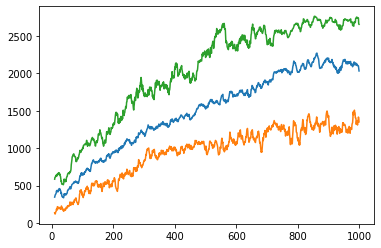

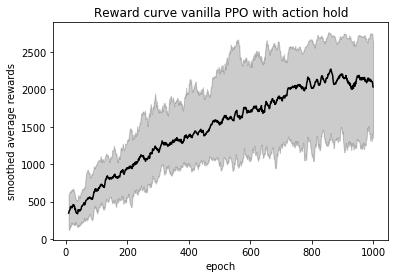

In [2]:
def control(env,q):
    k = np.array([-1000, 1000, -10, -10])
    goal = np.copy(env.state)
    goal[0] -= pi
    return -k.dot(goal)


seeds = [6,7,8,9]
load_paths = ['./data/acrobot_switch4/r3_longer_seed_' + str(seed) for seed in seeds]
#load_paths = ['./data/acrobot/sg_b' + str(seed) for seed in seeds]

avg_rewards = np.zeros((1000,))
rewards = np.zeros((1000,4))

for i, load_path in enumerate(load_paths):
    model, env, args, ws = load_workspace(load_path)
    
    avg_rewards += np.array((ws['avg_reward_hist']))
    rewards[:,i] = np.array((ws['avg_reward_hist']))
    #append(ws['avg_reward_hist'])
    #plt.title('reward vs epoch')
    #plt.figure()
    #plt.plot(ws['a'])
    #plt.figure()
    #plt.plot(ws['p_loss_hist'])
    #plt.figure()
    #plt.plot(ws['v_loss_hist'])
    #print(ws['num_states'])
    
avg_rewards /= 4
min_rewards = [np.min(rewards[i,:]) for i in range(1000)]
max_rewards = [np.max(rewards[i,:]) for i in range(1000)]
plt.plot(avg_rewards)
plt.plot(min_rewards)
plt.plot(max_rewards)

rewards_smoothed = pd.Series(avg_rewards).rolling(10, min_periods=10).mean()
min_smoothed =  pd.Series(min_rewards).rolling(10, min_periods=10).mean()
max_smoothed =  pd.Series(max_rewards).rolling(10, min_periods=10).mean()

plt.figure()
plt.plot(rewards_smoothed)
plt.plot(min_smoothed)
plt.plot(max_smoothed)

plt.figure()

epochs = [t for t in range(1000)]
plt.plot(rewards_smoothed, color='k')
plt.fill_between(epochs, min_smoothed, max_smoothed, color='k',alpha=.2 )
plt.xlabel('epoch')
plt.ylabel('smoothed average rewards')
plt.title('Reward curve vanilla PPO with action hold')

#plt.figure()
#plt.plot(np.array(ws['ep_path_tensor']))

1499
[2603.23792815]


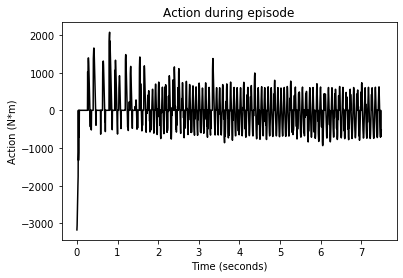

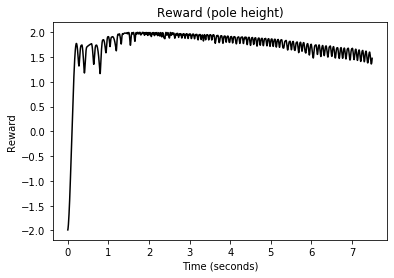

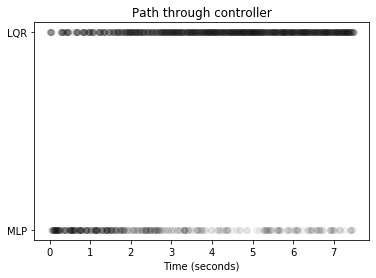

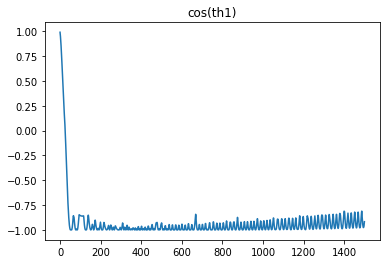

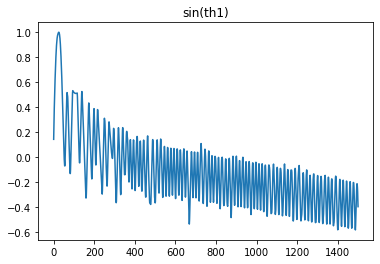

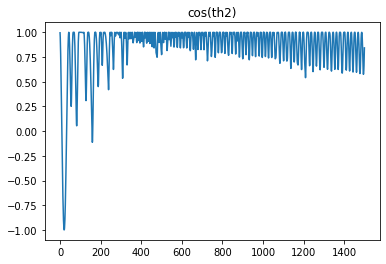

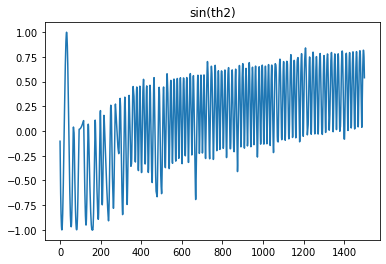

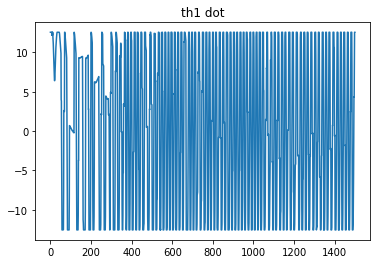

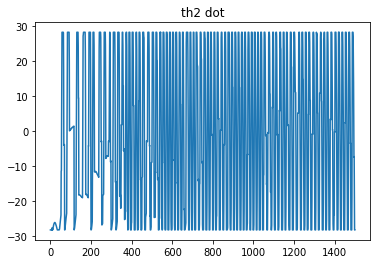

In [8]:
from seagul.nn import DummyNet

# Acrobot
load_path = './data/acrobot_switch4/r3_longer_seed_7'
model, env, args, ws = load_workspace(load_path)

#model.policy = DummyNet(6,1, 0,0,0)

model.env = env
myenv = env
myenv.num_steps=1500

#model.gate_fn.net_fn = gate
action_hist = np.zeros((myenv.num_steps,1))
state_hist = np.zeros((myenv.num_steps, myenv.observation_space.shape[0]))
reward_hist = np.zeros((myenv.num_steps, 1))
logp_hist = np.zeros((myenv.num_steps, 1))

#model.action_var = .1
#model.action_var = 1
#model.gate_var = .2

#model.action_var = 0
obs = myenv.reset()

for i in range(myenv.num_steps):
        actions, _, _, logp = model.step(obs)
        actions 
        #actions = np.zeros(1)
        #actions = np.clip(actions,-300, 300)
        obs, reward, done, _ = env.step(actions)        
        action_hist[i,:] = np.copy(actions)
        state_hist[i,:] = np.copy(obs)
        reward_hist[i,:] = np.copy(reward)
        logp_hist[i,:]   = logp
        #env.render()
        if done:
            break
            
            
gate_hist = [1 if p == 0 else 0 for p in logp_hist]
t = [.005*i for i in range(1500)]
plt.plot(t, action_hist, color='k')
plt.title('Action during episode')
plt.xlabel('Time (seconds)')
plt.ylabel('Action (N*m)')

plt.figure()
plt.plot(t, reward_hist, color='k')
plt.title('Reward (pole height)')
plt.xlabel('Time (seconds)')
plt.ylabel('Reward')

plt.figure()
plt.plot(t, gate_hist, 'o', color='k', alpha=.05)
plt.title('Path through controller')
plt.yticks([0,1],['MLP', 'LQR'])
plt.xlabel('Time (seconds)')

plt.figure()
plt.plot(state_hist[:,0])
plt.title("cos(th1)")

plt.figure()
plt.plot(state_hist[:,1])
plt.title("sin(th1)")

plt.figure()
plt.plot(state_hist[:,2])
plt.title("cos(th2)")

plt.figure()
plt.plot(state_hist[:,3])
plt.title("sin(th2)")

plt.figure()
plt.plot(state_hist[:,4])
plt.title("th1 dot")

plt.figure()
plt.plot(state_hist[:,5])
plt.title("th2 dot")

print(i)
print(sum(reward_hist))

In [ ]:
# Cartpole

myenv = env
myenv.num_steps=1500

#model.gate_fn.net_fn = gate
action_hist = np.zeros((myenv.num_steps,1))
state_hist = np.zeros((myenv.num_steps, myenv.observation_space.shape[0]))
reward_hist = np.zeros((myenv.num_steps, 1))

obs = env.reset()

for i in range(myenv.num_steps):
        actions, _, _, _ = model.step(obs)
        #actions = np.zeros(1)
        obs, reward, done, _ = env.step(actions)        
        action_hist[i,:] = np.copy(actions)
        state_hist[i,:] = np.copy(obs)
        reward_hist[i,:] = np.copy(reward)
        #env.render()
        if done:
            break

plt.plot(action_hist)
plt.figure()
plt.plot(reward_hist)

plt.figure()
plt.plot(state_hist[:,0])
plt.title("theta")

plt.figure()
plt.plot(state_hist[:,1])
plt.title("x")


plt.figure()
plt.plot(state_hist[:,2])
plt.title("theta dot")


plt.figure()
plt.plot(state_hist[:,3])
plt.title("xdot ")


print(i)
print(sum(reward_hist))

In [4]:
def control(env, q):
    k1 = 140.560
    k2 = -3.162*.1
    k3 = 41.772
    k4 = 0#-8.314
    u = -4*(k1 * (q[0] - pi) + k2 * q[1] + k3 * q[2] + k4 * q[3])
    return u

myenv = env
myenv.num_steps=2000

#model.gate_fn.net_fn = gate
action_hist = np.zeros((myenv.num_steps,1))
state_hist = np.zeros((myenv.num_steps, myenv.observation_space.shape[0]))
reward_hist = np.zeros((myenv.num_steps, 1))
path_hist = np.zeros((myenv.num_steps,1))

obs = env.reset()
#env.state[0] = np.pi
model.hyst_state = 0

for i in range(myenv.num_steps):
        if ((155 * pi/180 < obs[0] < 220 * pi/180)):
            actions = np.array(control(env, obs))/50
            #actions = np.zeros(1)
            path_hist[i]  = 1
        
        else:
            actions, _, _, _ = model.step(obs)
            path_hist[i] = 0
            
        
        actions = np.clip(actions, -75, 75)
        #actions = np.zeros(1)
        obs, reward, done, _ = env.step(actions)        
        action_hist[i,:] = np.copy(actions)
        state_hist[i,:] = np.copy(obs)
        reward_hist[i,:] = np.copy(reward)
        #env.render()
        if done:
            break

plt.plot(action_hist)
plt.title('action')


plt.figure()
plt.plot(path_hist)

plt.figure()
plt.plot(state_hist[:,0])
plt.title("theta")

plt.figure()
plt.plot(state_hist[:,1])
plt.title("x")


plt.figure()
plt.plot(state_hist[:,2])
plt.title("theta dot")


plt.figure()
plt.plot(state_hist[:,3])
plt.title("xdot ")

print(i)
print(sum(reward_hist))

NameError: name 'env' is not defined

In [ ]:
# Pretty print the ws keys

pprint(list(ws.keys()))

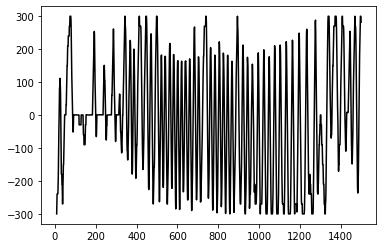

In [12]:
# SMoothed action plot

smooth_action = pd.Series(action_hist.reshape(-1)).rolling(10, min_periods=10).mean()
plt.plot(smooth_action, color='k')

In [22]:
# if you want this will load the policy after warm starting but before training

def control(env,q):
    k = np.array([-1000, 1000, -10, -10])
    goal = np.copy(env.state)
    goal[0] -= pi
    return -k.dot(goal)

env = gym.make('su_acrobot-v0')
model = switchedPpoModel(
     #policy = MLP(input_size, output_size, num_layers, layer_size, activation),
     policy = torch.load("policy_warm"),
     value_fn = torch.load("value_fn_warm"),
     #MLP(input_size, 1, num_layers, layer_size, activation),
     gate_fn  = torch.load("gate_fn_ac"),
     nominal_policy=control,
     env=env
)